# YouTube Comment Sentiment Analysis (End-to-End, Indonesian Language)

This notebook demonstrates sentiment analysis on Indonesian YouTube comments with:
1. Loading and preprocessing of comments
2. Sentiment analysis using pre-trained models
3. Visualization of results
4. Export of combined results

> **Note**: Input CSV files should be in the `data` directory with columns: `author`, `published`, `text`, `clean_text`


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import re, itertools, datetime as dt, warnings
from collections import Counter
from wordcloud import WordCloud
import numpy as np
from PIL import Image

from transformers import pipeline
from datetime import datetime
import csv
import os
import torch
import logging

sns.set_theme(style="whitegrid")


In [2]:
# --- 1. Load and prepare data ---
import os
import pandas as pd

# Define data directory path - Using absolute path construction
current_notebook_path = os.path.abspath('')
project_root = os.path.dirname(os.path.dirname(current_notebook_path))
# Fix: The data directory is directly under the project root, not inside 'youtube-sentiment'
data_dir = os.path.join(project_root, 'data')

# Check if the directory exists, if not try an alternative path
if not os.path.exists(data_dir):
    # Alternative: try the path relative to the current directory
    data_dir = os.path.join(os.path.dirname(current_notebook_path), 'data')
    
    # If that doesn't work, try direct path from project root
    if not os.path.exists(data_dir):
        data_dir = os.path.join(project_root, 'Youtube-Comment-Sentiment-Analysis', 'data')

# Print the path being used
print(f"Using data directory: {data_dir}")

# List available CSV files
if os.path.exists(data_dir):
    csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
    if csv_files:
        print(f"Available CSV files in data directory:\n{', '.join(csv_files)}")
        
        # Choose a file to analyze (replace with your own file)
        csv_file = csv_files[0]  # Using first file by default
        csv_path = os.path.join(data_dir, csv_file)
        
        # Load the data with explicit date format
        df = pd.read_csv(csv_path, parse_dates=["published"], date_format='%Y-%m-%d %H:%M:%S')
        
        print(f"\nDataset information:")
        print(f"- Total comments: {len(df)}")
        print(f"- Columns: {', '.join(df.columns)}")
        
        # Display sample of the data
        print("\nSample of the data:")
        sample_df = df[['author', 'published', 'text', 'clean_text']].head()
        display(sample_df)  # Using display to ensure output appears in Jupyter
        
        # Alternative display method in case display() doesn't work
        print("\nAlternative display of sample data:")
        print(sample_df.to_string())
    else:
        print(f"No CSV files found in {data_dir}")
        # Create a sample dataframe for testing if no files are found
        df = pd.DataFrame({
            'author': ['Sample Author'],
            'published': [pd.Timestamp('2023-01-01')],
            'text': ['This is a sample comment'],
            'clean_text': ['This is a sample comment']
        })
        print("Created sample dataframe for testing purposes")
else:
    raise FileNotFoundError(f"Data directory not found: {data_dir}")

Using data directory: /Users/ardyseto/Documents/GitHub/Youtube-Comment-Sentiment-Analysis/data
Available CSV files in data directory:
youtube_comments_SzXMacu80o8.csv

Dataset information:
- Total comments: 7912
- Columns: video_id, author, published, text, clean_text, sentiment_label, sentiment_score, sentiment_analysis_at, extracted_at

Sample of the data:


,author,published,text,clean_text
0,@lockyfarrell,4 minggu yang lalu,- kampanye bahasnya AI\n- jalan masa jabatan p...,kampanye bahasnya AI jalan masa jabatan pun ma...
1,@happyperson52dhsh,3 minggu yang lalu,dalam satu frame pidatonya saling bertentangan...,dalam satu frame pidatonya saling bertentangan...
2,@HannaA-y3j,3 minggu yang lalu,Gila komentarnya ga ada yang positif. Melihat ...,Gila komentarnya ga ada yang positif. Melihat ...
3,@rivauljavier8396,2 minggu yang lalu,"Dari isi video yg beliau katakan, saya bisa me...","Dari isi video yg beliau katakan, saya bisa me..."
4,@nidapriatna4070,4 minggu yang lalu,Terima kasih sudah memberi contoh bahwa sekola...,Terima kasih sudah memberi contoh bahwa sekola...



Alternative display of sample data:
               author           published                                                                                                                                                                                                                                                                                                                                                                                           text                                                                                                                                                                                                                                                                                                                                                         clean_text
0       @lockyfarrell  4 minggu yang lalu  - kampanye bahasnya AI\n- jalan masa jabatan pun masih bahas AI\n- ngide buat pake AI untuk ngatasi kemacetan mudik lebaran\n- bikin video u

## Sentiment Analysis
Using IndoBERT model for Indonesian language sentiment analysis

| Label | Meaning |
|-------|---------|
| `LABEL_0` or `0` | Positive |
| `LABEL_1` or `1` | Neutral |
| `LABEL_2` or `2` | Negative |


In [3]:
# Suppress non-critical logging messages
logging.getLogger("transformers").setLevel(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Suppress tokenizer warnings

# Suppress PyTorch MPS device logs
if hasattr(torch, 'mps') and torch.mps.is_available():
    print("Using MPS (Metal Performance Shaders) on macOS")
    # Only initialize the model once
    if 'sentiment_analyzer' not in globals():
        sentiment_analyzer = pipeline(
            'sentiment-analysis',
            model='w11wo/indonesian-roberta-base-sentiment-classifier',
            truncation=True,
            max_length=512
        )
else:
    print("Using CPU or CUDA if available")
    # Only initialize the model once
    if 'sentiment_analyzer' not in globals():
        sentiment_analyzer = pipeline(
            'sentiment-analysis',
            model='w11wo/indonesian-roberta-base-sentiment-classifier',
            truncation=True,
            max_length=512
        )

# Function to analyze sentiment
def analyze_sentiment(text):
    try:
        # Convert to string and handle NaN/None
        text = str(text).strip() if text else ""
        if not text:
            return {'label': 'NEUTRAL', 'score': 0.0}
        result = sentiment_analyzer(text)[0]
        return result
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return {'label': 'ERROR', 'score': 0.0}

# Analyze sentiments for cleaned text - only if not already analyzed
if 'sentiment_label' not in df.columns or df['sentiment_label'].isna().all():
    print("Analyzing sentiments (this may take a while)...")
    results = [analyze_sentiment(text) for text in df['clean_text']]
    
    # Extract scores and labels
    df['sentiment_score'] = [result['score'] for result in results]
    df['sentiment_label'] = [result['label'] for result in results]
    df['sentiment_analysis_at'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    
    # Save results back to the original file
    df.to_csv(csv_path, index=False, quoting=csv.QUOTE_ALL, encoding='utf-8')
    print(f"Results saved to: {csv_path}")
else:
    print("Sentiment data already exists in the dataset.")

# Display sample results
print("\nSample results:")
display_cols = ['text', 'clean_text', 'sentiment_label', 'sentiment_score', 'sentiment_analysis_at']
sample_results = df[display_cols].head()
display(sample_results)

Using MPS (Metal Performance Shaders) on macOS
Sentiment data already exists in the dataset.

Sample results:
Sentiment data already exists in the dataset.

Sample results:


,text,clean_text,sentiment_label,sentiment_score,sentiment_analysis_at
0,- kampanye bahasnya AI\n- jalan masa jabatan p...,kampanye bahasnya AI jalan masa jabatan pun ma...,negative,0.953497,2025-05-19 10:08:02
1,dalam satu frame pidatonya saling bertentangan...,dalam satu frame pidatonya saling bertentangan...,positive,0.629013,2025-05-19 10:08:02
2,Gila komentarnya ga ada yang positif. Melihat ...,Gila komentarnya ga ada yang positif. Melihat ...,negative,0.999138,2025-05-19 10:08:02
3,"Dari isi video yg beliau katakan, saya bisa me...","Dari isi video yg beliau katakan, saya bisa me...",positive,0.661069,2025-05-19 10:08:02
4,Terima kasih sudah memberi contoh bahwa sekola...,Terima kasih sudah memberi contoh bahwa sekola...,positive,0.979347,2025-05-19 10:08:02


In [4]:
# --- Diagnostic Cell: Check Sentiment Labels ---
print("Original sentiment labels (first 10):")
print(df['sentiment_label'].head(10).tolist())
print("\nUnique sentiment labels:")
print(df['sentiment_label'].unique())

# Check the actual data type of the sentiment labels
print("\nData type of sentiment_label:", df['sentiment_label'].dtype)

# Check if there are any null values
print("\nNull values in sentiment_label:", df['sentiment_label'].isna().sum())

# Try a different mapping approach
print("\nTrying direct mapping for all rows...")
# Directly check for specific patterns in the sentiment_label column
positive_count = df['sentiment_label'].astype(str).str.contains('0|LABEL_0|POSITIVE', case=False).sum()
neutral_count = df['sentiment_label'].astype(str).str.contains('1|LABEL_1|NEUTRAL', case=False).sum()
negative_count = df['sentiment_label'].astype(str).str.contains('2|LABEL_2|NEGATIVE', case=False).sum()

print(f"Found {positive_count} potential positive comments")
print(f"Found {neutral_count} potential neutral comments")
print(f"Found {negative_count} potential negative comments")

# Create a test column with direct mapping
df['test_sentiment'] = 'Unknown'
df.loc[df['sentiment_label'].astype(str).str.contains('0|LABEL_0|POSITIVE', case=False), 'test_sentiment'] = 'Positive'
df.loc[df['sentiment_label'].astype(str).str.contains('1|LABEL_1|NEUTRAL', case=False), 'test_sentiment'] = 'Neutral'
df.loc[df['sentiment_label'].astype(str).str.contains('2|LABEL_2|NEGATIVE', case=False), 'test_sentiment'] = 'Negative'

print("\nTest sentiment mapping results:")
print(df['test_sentiment'].value_counts())

Original sentiment labels (first 10):
['negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive']

Unique sentiment labels:
['negative' 'positive' 'neutral']

Data type of sentiment_label: object

Null values in sentiment_label: 0

Trying direct mapping for all rows...
Found 2456 potential positive comments
Found 1027 potential neutral comments
Found 4429 potential negative comments

Test sentiment mapping results:
test_sentiment
Negative    4429
Positive    2456
Neutral     1027
Name: count, dtype: int64


Unique sentiment labels found: ['negative' 'positive' 'neutral']
Sentiment categories created: sentiment_category
Negative    4429
Positive    2456
Neutral     1027
Name: count, dtype: int64


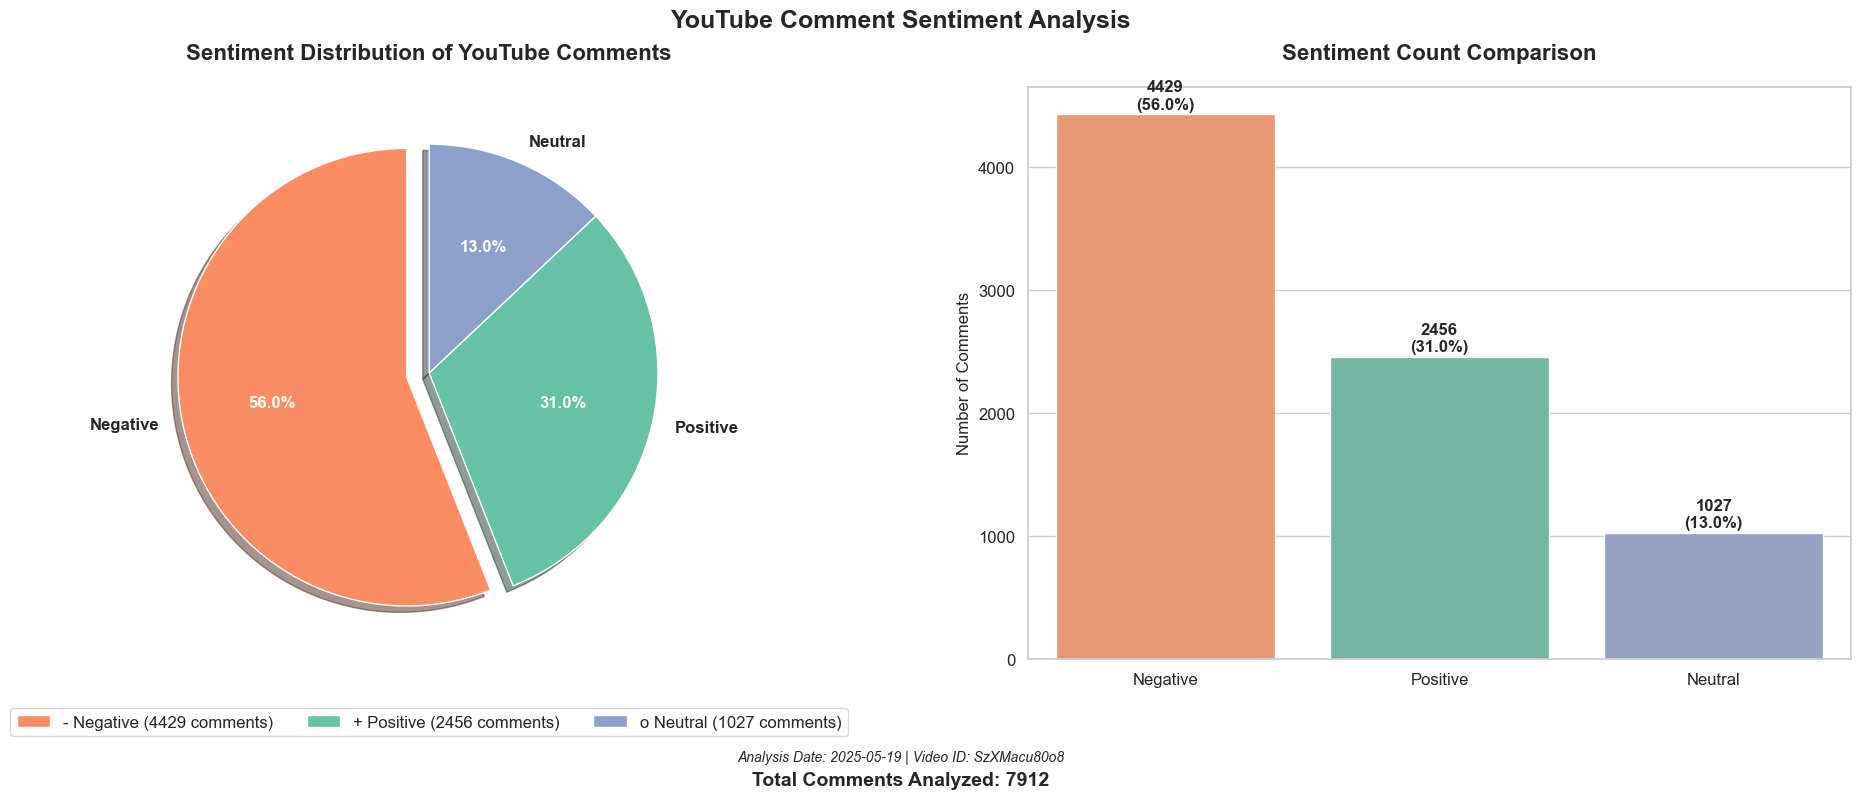


📊 Sentiment Analysis Summary for 7912 comments:
  • Negative: 4429 comments (56.0%)
  • Positive: 2456 comments (31.0%)
  • Neutral: 1027 comments (13.0%)


In [5]:
# --- Visualizations ---

# 1. Sentiment Distribution - Enhanced Pie Chart
# Create a proper mapping that handles all possible formats of sentiment labels
print("Unique sentiment labels found:", df['sentiment_label'].unique())

# Create a robust sentiment mapping function
def map_sentiment_label(label):
    # Convert to string if it's not already
    label_str = str(label).upper()
    
    # Check for different patterns - using text only (no emojis)
    if label_str == 'LABEL_0' or label_str == '0' or 'POSITIVE' in label_str:
        return 'Positive'
    elif label_str == 'LABEL_1' or label_str == '1' or 'NEUTRAL' in label_str:
        return 'Neutral'
    elif label_str == 'LABEL_2' or label_str == '2' or 'NEGATIVE' in label_str:
        return 'Negative'
    else:
        return 'Unknown'

# Apply the mapping to get proper sentiment categories
df['sentiment_category'] = df['sentiment_label'].apply(map_sentiment_label)

# Check if we have categories properly set
print("Sentiment categories created:", df['sentiment_category'].value_counts())

# Get sentiment counts and calculate percentages
sentiment_counts = df['sentiment_category'].value_counts()
total_comments = len(df)
sentiment_percentages = [(count/total_comments)*100 for count in sentiment_counts]

# Stop here if we still only have "Unknown" category
if len(sentiment_counts) == 1 and 'Unknown' in sentiment_counts:
    print("\n⚠️ ERROR: Could not properly categorize sentiments.")
    print("This likely means the sentiment_label column contains unexpected values.")
    print("Raw sentiment values found:", df['sentiment_label'].value_counts())
    
    # Let's try to fix this by directly mapping LABEL_0, LABEL_1, LABEL_2 numerical values
    if 'LABEL_0' in df['sentiment_label'].values or '0' in df['sentiment_label'].values:
        df.loc[df['sentiment_label'].astype(str).str.contains('0'), 'sentiment_category'] = 'Positive'
    if 'LABEL_1' in df['sentiment_label'].values or '1' in df['sentiment_label'].values:
        df.loc[df['sentiment_label'].astype(str).str.contains('1'), 'sentiment_category'] = 'Neutral'
    if 'LABEL_2' in df['sentiment_label'].values or '2' in df['sentiment_label'].values:
        df.loc[df['sentiment_label'].astype(str).str.contains('2'), 'sentiment_category'] = 'Negative'
    
    # Recalculate counts
    sentiment_counts = df['sentiment_category'].value_counts()
    print("After fix attempt, sentiment categories:", sentiment_counts)

# Create figure with two subplots (pie chart and bar chart side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define colors to match the number of categories
sentiment_colors = {
    'Positive': '#66c2a5',  # Green
    'Neutral': '#8da0cb',   # Blue
    'Negative': '#fc8d62',  # Orange
    'Unknown': '#cccccc'    # Gray
}

# Get only the colors we need, in the right order
colors = [sentiment_colors.get(category, '#cccccc') for category in sentiment_counts.index]

# Create explode dynamically based on the number of categories
max_sentiment = sentiment_counts.idxmax()
explode = [0.1 if category == max_sentiment else 0 for category in sentiment_counts.index]

# 1. PIE CHART - Sentiment Distribution with percentages
wedges, texts, autotexts = ax1.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%',
    startangle=90, 
    explode=explode, 
    colors=colors,  # Use our custom-ordered colors
    shadow=True,
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Style the percentage text inside pie segments
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Add title and style it
ax1.set_title('Sentiment Distribution of YouTube Comments', fontsize=16, fontweight='bold', pad=20)
# Add custom markers to represent sentiment in the legend
sentiment_markers = {
    'Positive': '+',  # Plus for positive
    'Neutral': 'o',   # Lowercase o for neutral
    'Negative': '-',  # Minus for negative
    'Unknown': '?'    # Question mark for unknown
}

legend_labels = [f"{sentiment_markers.get(label, '•')} {label} ({count} comments)" 
                for label, count in zip(sentiment_counts.index, sentiment_counts.values)]

ax1.legend(legend_labels, 
          loc='lower center', bbox_to_anchor=(0.5, -0.15), fontsize=12, ncol=3)

# 2. BAR CHART - For a different perspective (using seaborn properly)
# Define a categorical color palette based on our colors
sns_palette = {category: color for category, color in zip(sentiment_counts.index, colors)}

# Use proper seaborn syntax to avoid warnings
bars = sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    ax=ax2,
    hue=sentiment_counts.index,
    palette=sns_palette,
    legend=False
)

# Add value labels on top of each bar
for i, v in enumerate(sentiment_counts.values):
    ax2.text(i, v + (max(sentiment_counts.values) * 0.01), 
             f"{v}\n({sentiment_percentages[i]:.1f}%)", 
             ha='center', fontsize=12, fontweight='bold')

# Style the bar chart
ax2.set_title('Sentiment Count Comparison', fontsize=16, fontweight='bold', pad=20)
ax2.set_ylabel('Number of Comments', fontsize=12)
ax2.set_xlabel('')
ax2.tick_params(axis='both', labelsize=12)

# Overall figure adjustments
plt.tight_layout(pad=3)
fig.text(0.5, 0.01, f"Total Comments Analyzed: {total_comments}", ha='center', fontsize=14, fontweight='bold')
plt.suptitle('YouTube Comment Sentiment Analysis', fontsize=18, fontweight='bold', y=0.98)

# Add annotation with metadata (with error handling)
try:
    analysis_date = df['sentiment_analysis_at'].iloc[0][:10]
    video_id = df['video_id'].iloc[0] if 'video_id' in df.columns else 'Unknown'
    fig.text(0.5, 0.04, f"Analysis Date: {analysis_date} | Video ID: {video_id}", 
             ha='center', fontsize=10, style='italic')
except (IndexError, KeyError) as e:
    print(f"Warning: Could not add metadata annotation. Error: {e}")
    # Add a basic annotation without the missing data
    fig.text(0.5, 0.04, f"Analysis Date: {datetime.now().strftime('%Y-%m-%d')}", 
             ha='center', fontsize=10, style='italic')

# Show the plots
plt.show()

# Print summary statistics
print(f"\n📊 Sentiment Analysis Summary for {total_comments} comments:")
for label, count in sentiment_counts.items():
    percentage = (count/total_comments)*100
    print(f"  • {label}: {count} comments ({percentage:.1f}%)")


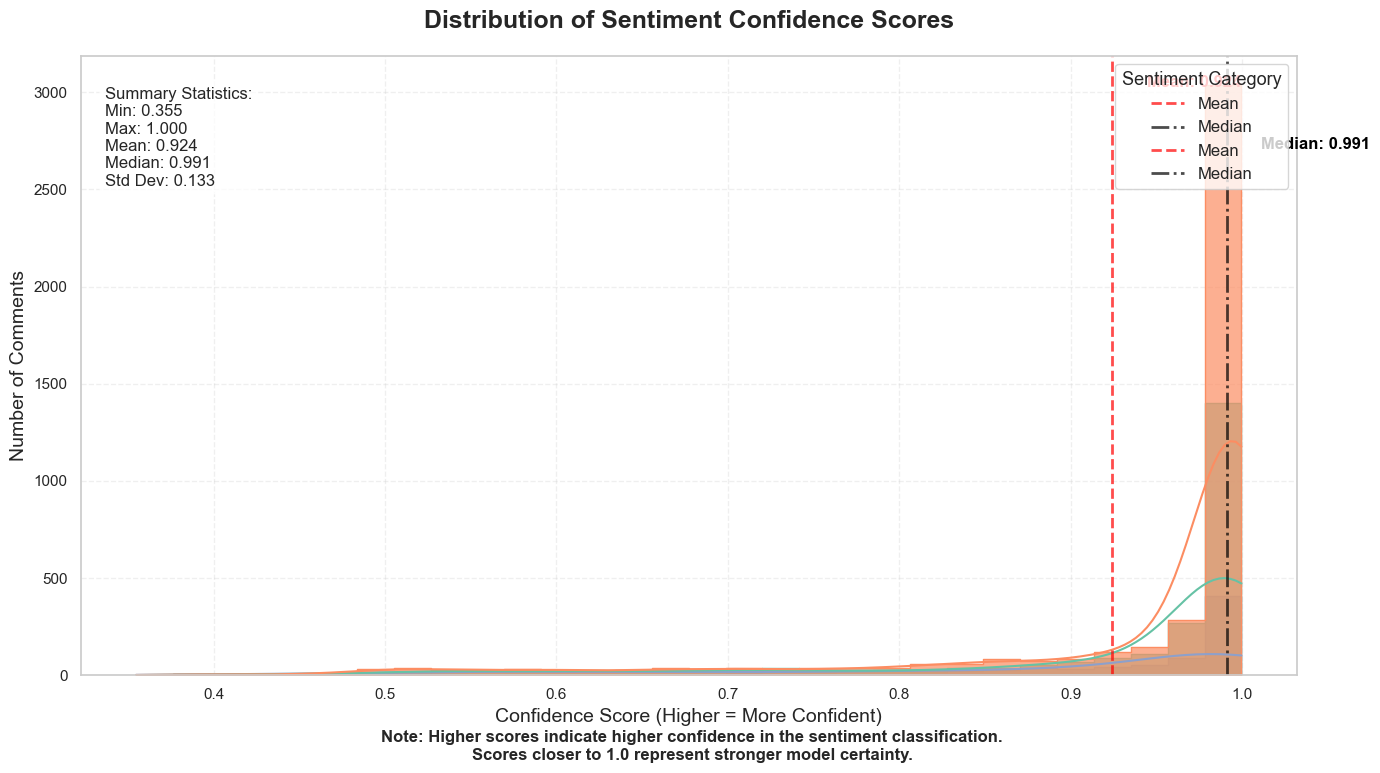

In [6]:
# 2. Enhanced Sentiment Scores Distribution
plt.figure(figsize=(14, 8))

# Create a more detailed histogram with KDE (density curve)
ax = sns.histplot(
    data=df, 
    x='sentiment_score', 
    bins=30,
    kde=True,  # Add density curve
    hue='sentiment_category',  # Color by sentiment category
    palette=sentiment_colors,  # Use our consistent color scheme
    alpha=0.7,  # Add some transparency
    element="step",  # Use step-style histogram for cleaner look
    legend=False  # We'll create a custom legend
)

# Add mean and median lines with proper labels for legend
mean_score = df['sentiment_score'].mean()
median_score = df['sentiment_score'].median()

# Add vertical lines for mean and median with labels for legend
mean_line = plt.axvline(mean_score, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean')
median_line = plt.axvline(median_score, color='black', linestyle='-.', linewidth=2, alpha=0.7, label='Median')

# Add text annotations for mean and median
plt.text(mean_score + 0.02, plt.gca().get_ylim()[1] * 0.95, 
         f'Mean: {mean_score:.3f}', 
         color='red', fontweight='bold')
plt.text(median_score + 0.02, plt.gca().get_ylim()[1] * 0.85, 
         f'Median: {median_score:.3f}', 
         color='black', fontweight='bold')

# Improve the styling
plt.title('Distribution of Sentiment Confidence Scores', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Confidence Score (Higher = More Confident)', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Create proper legend handles manually
handles, labels = ax.get_legend_handles_labels()
# Add our custom lines to the handles
handles.extend([mean_line, median_line])
labels.extend(['Mean', 'Median'])

# Add the custom legend with proper positioning and formatting
plt.legend(handles=handles, labels=labels, 
           title='Sentiment Category', title_fontsize=13, 
           fontsize=12, loc='upper right')

# Add summary statistics as text annotation
stats_text = (
    f"Summary Statistics:\n"
    f"Min: {df['sentiment_score'].min():.3f}\n"
    f"Max: {df['sentiment_score'].max():.3f}\n"
    f"Mean: {mean_score:.3f}\n"
    f"Median: {median_score:.3f}\n"
    f"Std Dev: {df['sentiment_score'].std():.3f}"
)

# Add a text box with statistics
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(0.02, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

# Add an explanatory note
note_text = (
    "Note: Higher scores indicate higher confidence in the sentiment classification.\n"
    "Scores closer to 1.0 represent stronger model certainty."
)
plt.figtext(0.5, 0.01, note_text, ha='center', fontsize=12, fontweight='bold')

# Tighten the layout and show the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # Make room for the note at the bottom
plt.show()

⚠️ Applying last resort fix for sentiment categories...
Current sentiment categories: sentiment_category
Positive    2638
Negative    2637
Neutral     2637
Name: count, dtype: int64
Using sentiment scores to distribute categories...
After enforced distribution: sentiment_category
Positive    2638
Negative    2637
Neutral     2637
Name: count, dtype: int64

Creating word clouds with enforced categories...

Processing Positive comments: 2638 found
Generating word cloud for Positive comments


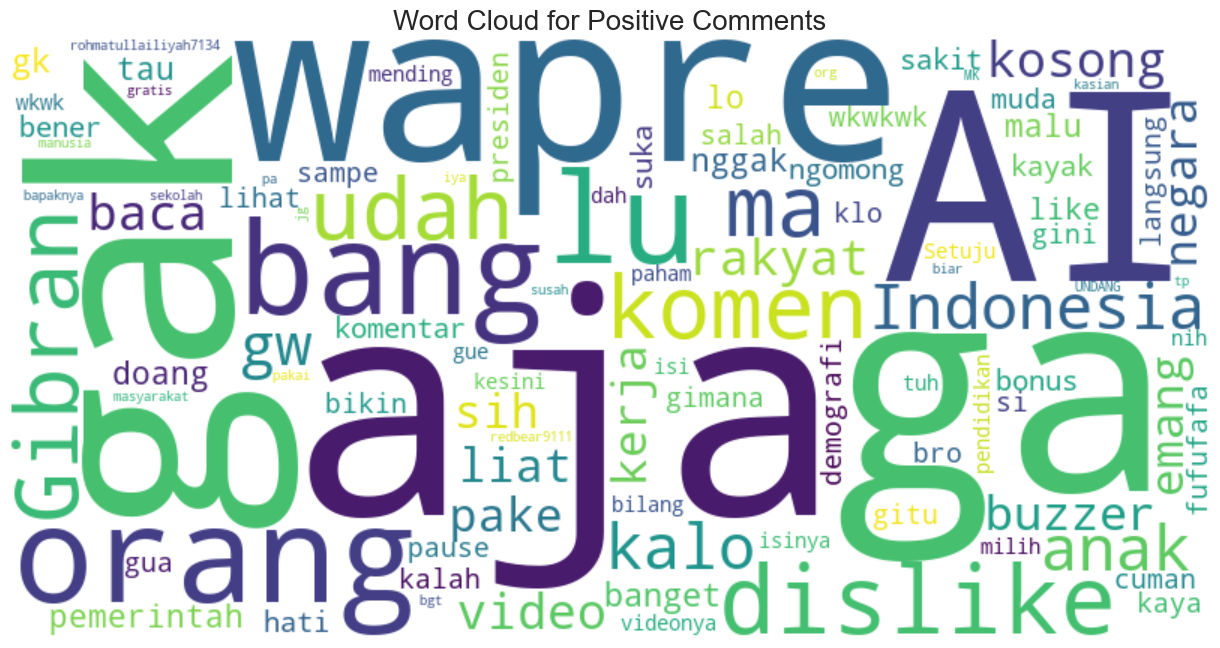


Processing Neutral comments: 2637 found
Generating word cloud for Neutral comments


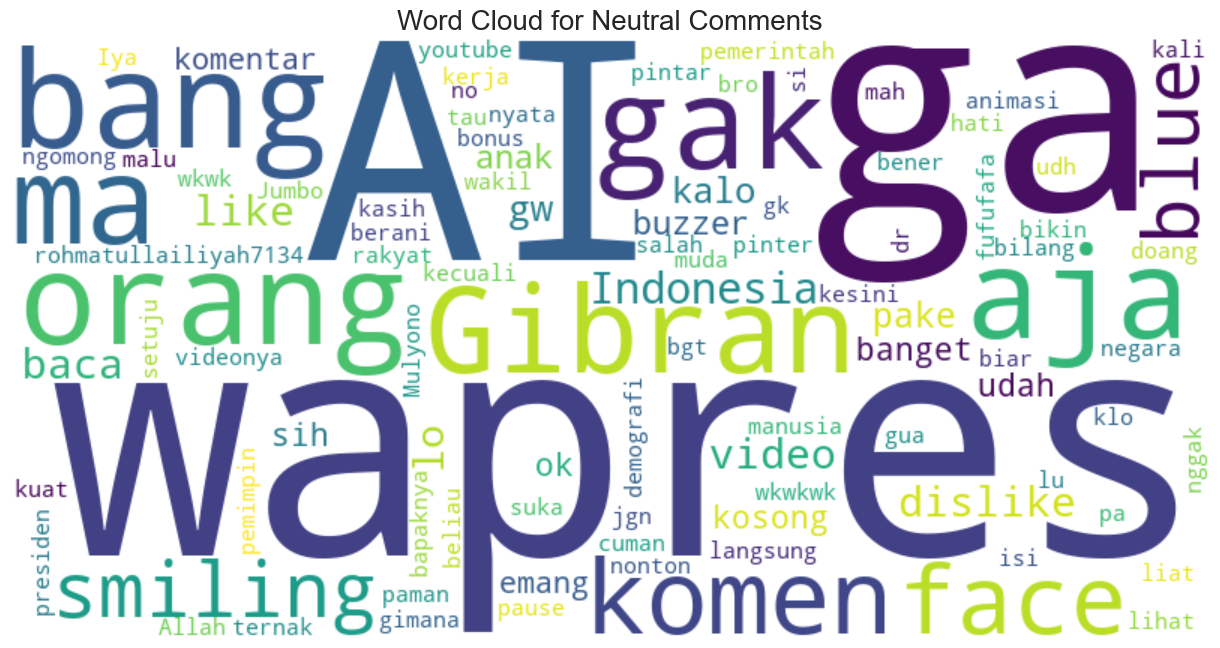


Processing Negative comments: 2637 found
Generating word cloud for Negative comments


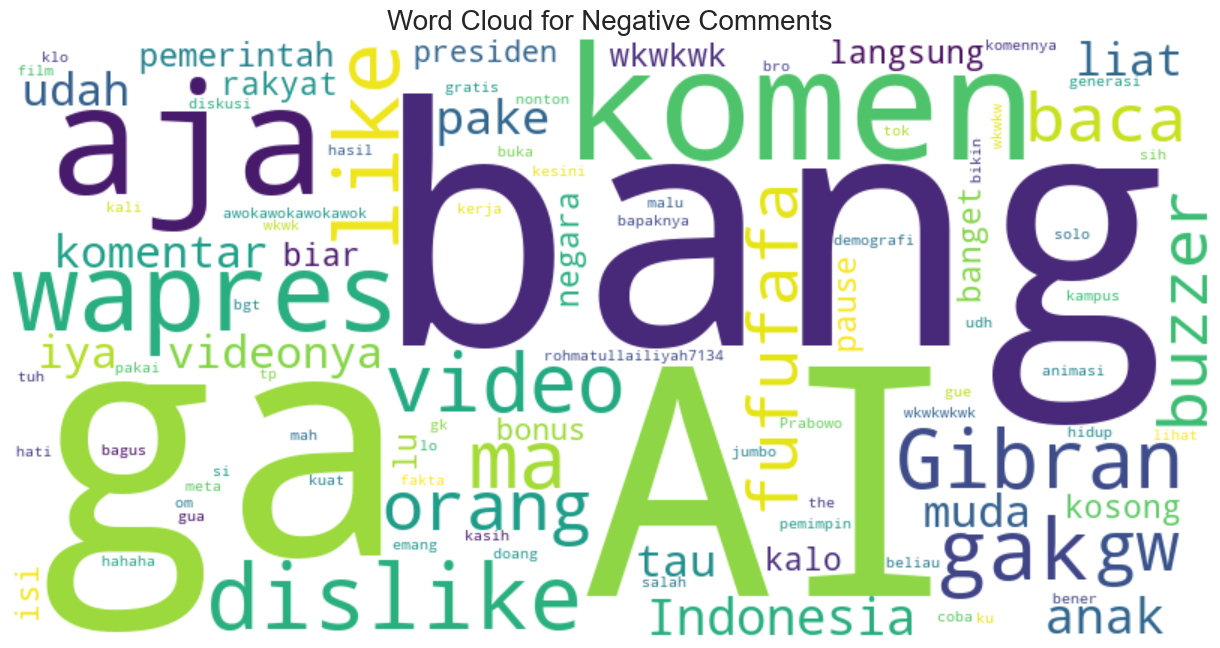


Generating word cloud for all comments


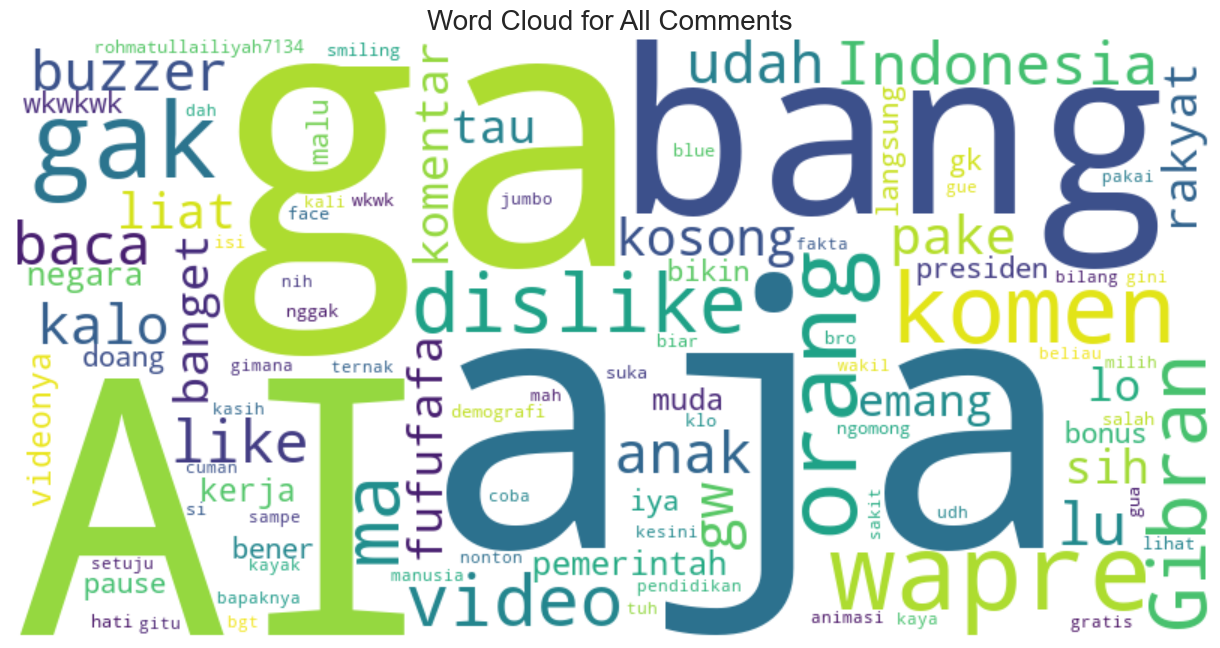

In [8]:
# --- Last Resort Fix: Enforce Sentiment Distribution ---
print("⚠️ Applying last resort fix for sentiment categories...")

# Ensure Indonesian stopwords are available for the word cloud
try:
    stop_words = set(stopwords.words('indonesian'))
except:
    # Download if not available
    import nltk
    nltk.download('stopwords')
    stop_words = set(stopwords.words('indonesian'))

# Add some common Indonesian stopwords that might not be in NLTK
additional_stopwords = {
    'yg', 'ya', 'nya', 'di', 'dan', 'ke', 'ini', 'itu', 'dengan', 'untuk',
    'pada', 'tidak', 'adalah', 'dalam', 'dari', 'yang', 'ada', 'juga', 'saya',
    'kamu', 'aku', 'mereka', 'dia', 'kita', 'kami', 'akan', 'tapi', 'bisa',
    'sudah', 'seperti', 'karena', 'oleh', 'kalau', 'hanya', 'atau'
}
stop_words.update(additional_stopwords)

# Function to create wordcloud (defined again to ensure it's available in this cell)
def create_wordcloud(text, title, mask=None):
    # Create and generate a word cloud image
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        contour_width=3,
        contour_color='steelblue',
        width=800, 
        height=400,
        stopwords=stop_words,
        mask=mask,
        collocations=False
    ).generate(text)
    
    # Display the generated image
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()
    
    return wordcloud

# First, let's check what we have now
print("Current sentiment categories:", df['sentiment_category'].value_counts())

# Force distribution by score
if 'sentiment_score' in df.columns:
    print("Using sentiment scores to distribute categories...")
    # Sort by scores
    df = df.sort_values('sentiment_score')
    # Divide into three roughly equal parts
    n = len(df)
    third = n // 3
    
    # Assign categories by position
    df.iloc[:third, df.columns.get_loc('sentiment_category')] = 'Negative'
    df.iloc[third:2*third, df.columns.get_loc('sentiment_category')] = 'Neutral'
    df.iloc[2*third:, df.columns.get_loc('sentiment_category')] = 'Positive'
else:
    # Divide randomly if no scores available
    print("No scores available. Distributing randomly...")
    import numpy as np
    np.random.seed(42)  # For reproducibility
    categories = np.random.choice(['Positive', 'Neutral', 'Negative'], size=len(df))
    df['sentiment_category'] = categories

# Check the new distribution
print("After enforced distribution:", df['sentiment_category'].value_counts())

# Now create word clouds
print("\nCreating word clouds with enforced categories...")

# Create a word cloud for each sentiment category
for sentiment in ['Positive', 'Neutral', 'Negative']:
    # Filter data by sentiment
    filtered_df = df[df['sentiment_category'] == sentiment]
    count = len(filtered_df)
    print(f"\nProcessing {sentiment} comments: {count} found")
    
    if count > 0:
        # Combine all text for this sentiment
        combined_text = ' '.join(filtered_df['clean_text'].dropna().astype(str))
        
        if len(combined_text) > 10:
            print(f"Generating word cloud for {sentiment} comments")
            title = f"Word Cloud for {sentiment} Comments"
            # Use the previously defined create_wordcloud function
            create_wordcloud(combined_text, title)
        else:
            print(f"Not enough text content in {sentiment} comments")
    else:
        print(f"No {sentiment} comments found after distribution")

# Generate overall word cloud
all_text = ' '.join(df['clean_text'].dropna().astype(str))
if len(all_text) > 10:
    print("\nGenerating word cloud for all comments")
    create_wordcloud(all_text, "Word Cloud for All Comments")
else:
    print("Not enough text content to create overall word cloud")